# ASR correlation with film thickness

In [1]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.pickletools import pickle_dict
from helpers.plotting import quat_slice_scatter, add_colorbar, scatter_slices
from helpers.quaternary_plt import QuaternaryAxes
from helpers.outlier_detect import DataCleaner

import pymatgen as mg
import pypif.pif

from ipywidgets import interact, interact_manual, fixed

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') 
#pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')
pickledir = os.path.join(tcodir,'scripts/pickles')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

# Load data

In [3]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['ASR'] > 0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_ASR'] = np.log10(data['ASR'])

## Calculate radial distance

In [12]:
#calculate distance from center of film
center = (-20,21)
data['r_mm'] =  ((data['x_mm'] - center[0])**2 + (data['y_mm'] - center[1])**2)**0.5

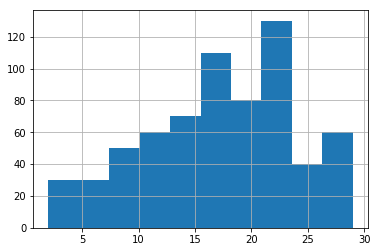

In [13]:
data['r_mm'].hist()

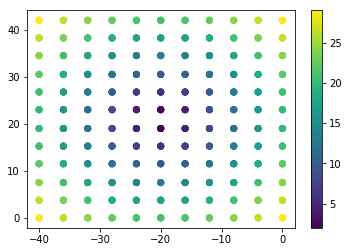

In [17]:
plt.scatter(data['x_mm'],data['y_mm'],c=data['r_mm'])
plt.colorbar()

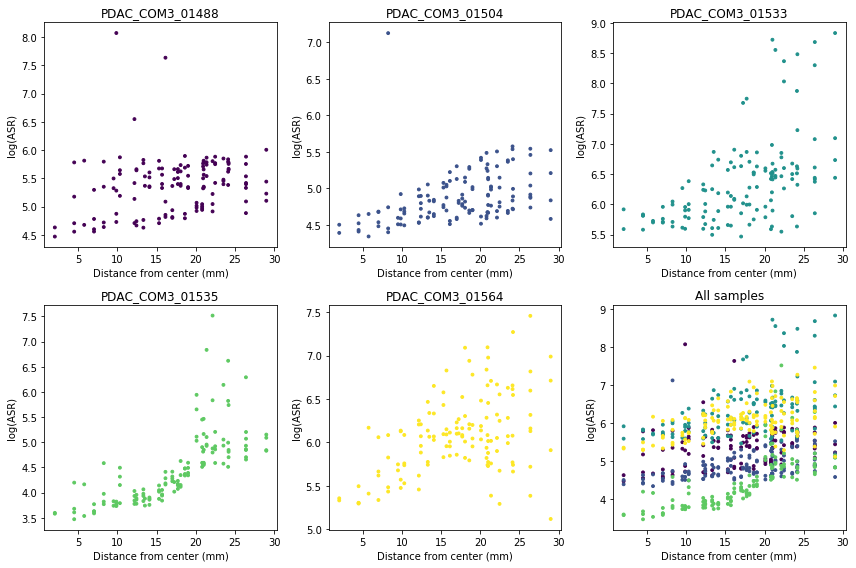

In [44]:
#dict to map sample to int for colormap
samples = data['sample'].unique()
colors = np.arange(len(samples))
sample_map = dict(zip(samples,colors))

fig, axes = plt.subplots(2,3,figsize=(12,8))
for sample,ax in zip(samples,axes.ravel()):
    df = data[data['sample']==sample]
    #fig, ax = plt.subplots()
    ax.scatter(df['r_mm'],df['log_ASR'],c=df['sample'].map(sample_map),s=8,vmin=min(colors),vmax=max(colors))
    ax.set_title(sample)
    ax.set_xlabel('Distance from center (mm)')
    ax.set_ylabel('log(ASR)')
#plt.scatter(data['r_mm'],data['log_ASR'],c=data['sample'].map(sample_map),s=8)
axes.ravel()[-1].scatter(data['r_mm'],data['log_ASR'],c=data['sample'].map(sample_map),s=8)
axes.ravel()[-1].set_title('All samples')
axes.ravel()[-1].set_xlabel('Distance from center (mm)')
axes.ravel()[-1].set_ylabel('log(ASR)')

fig.tight_layout()

## Remove outliers

In [47]:
dc = DataCleaner(data,'log_ASR',DB_kw={'eps':0.25},IF_kw={'contamination':0.1})
dc.fit_predict(z_thresh=2)
dc.remove_outliers()
clean_data = dc.clean_data

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


# Set up features

In [48]:
#load pickles
calc_feat_Co23Fe34 = pickle_dict(os.path.join(pickledir,'feat_Co23Fe34'))
calc_feat_Co24Fe24 = pickle_dict(os.path.join(pickledir,'feat_Co24Fe24'))

input_2334 = pd.DataFrame()
input_2424 = pd.DataFrame()
y = clean_data['log_ASR']
#calculate features
for idx in clean_data.index:
    row = clean_data.loc[idx,:]
    formula = row['formula']
    try:
        f2334 = calc_feat_Co23Fe34.dict[formula]
    except KeyError:
        f2334 = formula_redfeat(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]})
        calc_feat_Co23Fe34.dict[formula] = f2334
    try:
        f2424 = calc_feat_Co24Fe24.dict[formula]
    except KeyError:
        f2424 = formula_redfeat(formula,cat_ox_lims={'Co':[2,4],'Fe':[2,4]})
        calc_feat_Co24Fe24.dict[formula] = f2424
        
    f2334['formula'] = formula
    input_2334 = input_2334.append(pd.Series(f2334),ignore_index=True)
    f2424['formula'] = formula
    input_2424 = input_2424.append(pd.Series(f2424),ignore_index=True)

calc_feat_Co23Fe34.update_file()
calc_feat_Co24Fe24.update_file()

Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co23Fe34
Dumped pickle to C:\Users\jdhuang\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\scripts/pickles\feat_Co24Fe24


In [ ]:
#add radial distance
input_2334['dist_from_center'] = clean_data['r_mm'].values

# Model build


In [174]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics.pairwise import pairwise_kernels, polynomial_kernel
from sklearn.model_selection import KFold

from ipywidgets import interact, interact_manual, fixed

In [107]:
test = np.array([[0,1],[2,3]])
#test.repeat(2,axis=1)

test, poly_transform(test,[0],add_exp=True)

(array([[0, 1],
        [2, 3]]),
 array([[ 1.        ,  1.        ,  1.        ,  1.        ,  0.36787944,
          2.71828183],
        [ 1.        ,  0.13533528,  7.3890561 ,  1.        ,  0.04978707,
         20.08553692]]))

In [108]:
np.exp(-test)

array([[1.        , 0.36787944],
       [0.13533528, 0.04978707]])

In [120]:
def poly_transform(X,powers,inf_val=1e6,add_exp=False):

    #each power needs to be applied to each column
    cpowers = np.array(powers*X.shape[1])
    Xr = X.repeat(len(powers),axis=1)

    #matrix to track and retain signs
    Xr_sign = np.sign(Xr)
    #zeros get 0 sign - change to 1
    Xr_sign[Xr_sign==0] = 1
    #elements that will be raised to even powers must be positive after operation - set signs to 1
    power_flag = (cpowers%2!=0).astype(int) #flag for non-even powers in cpowers
    Xr_sign = np.apply_along_axis(lambda x: x**power_flag, 1, Xr_sign) 
        #if even, flag = 0 -> sign becomes 1
        #if not even, flag=1 -> sign unchanged
    

    #feed absolute values in to allow square root of negatives, then reapply signs
    Xt = Xr_sign*(np.abs(Xr)**cpowers)
    
    #add exponential terms if specified
    if add_exp==True:
        #create new array with extra columns for exponentials
        Xt2 = np.zeros((Xt.shape[0], Xt.shape[1] + 2*X.shape[1]))
        for i in range(X.shape[1]):
            #fill leftmost columns with polynomial terms
            Xt2[:,i*(len(powers) + 2):(i+1)*(len(powers) + 2) - 2] = Xt[:,i*len(powers):(i+1)*len(powers)]
            #fill last 2 columns for each variable with exponential terms
            Xt2[:,(i+1)*(len(powers) + 2) - 2] = np.exp(-X[:,i]) #e^-x
            Xt2[:,(i+1)*(len(powers) + 2) - 1] = np.exp(X[:,i]) #e^x
        Xt = Xt2
        
    #set infinite values to inf_val
    Xt[Xt==np.inf] = inf_val
    
    return Xt

#set up and transform data
drop = ['formula','A_sum','X_a','X_cat_a_oxavg','mass_a','n_a_oxavg','r_a_oxavg']
#drop = drop + ['Ba_amt','Co_amt','Fe_amt','Zr_amt','Y_amt'] #remove _amt features - not extensible beyond BCFZY
base_features = input_2334.drop(drop,axis=1).columns.values
X = input_2334.drop(drop,axis=1).values
y = clean_data['log_ASR'].values
clusters = clean_data['sample'].values

#poly transform
powers = [-3,-2,-1,-1/2,1/2,1,2,3]
Xt = poly_transform(X,powers,add_exp=True)

#check for infs and nans
np.sum(np.isnan(Xt).astype(int)), np.sum(np.isinf(Xt).astype(int))

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


(0, 0)

In [117]:
base_features[3]

'Co:Fe_ratio'

In [119]:
np.exp(1e3)

inf

In [118]:
X[:,3]

array([1.33788172e+00, 1.17985544e+00, 1.05323396e+00, 9.37618629e-01,
       8.28826400e-01, 7.41281871e-01, 6.64510608e-01, 5.99282757e-01,
       5.50548083e-01, 5.05478302e-01, 4.73284968e-01, 1.39041536e+00,
       1.23495647e+00, 1.10401594e+00, 9.85404688e-01, 8.69537167e-01,
       7.77696675e-01, 6.98436804e-01, 6.32410571e-01, 5.81246488e-01,
       5.33434183e-01, 4.98038046e-01, 1.44647401e+00, 1.29410782e+00,
       1.15851602e+00, 1.03706663e+00, 9.13434842e-01, 8.16733627e-01,
       7.34962765e-01, 6.68391333e-01, 6.14424693e-01, 5.63714850e-01,
       5.24699919e-01, 1.51075114e+00, 1.36213491e+00, 1.22127914e+00,
       1.09700676e+00, 9.64126246e-01, 8.61548383e-01, 7.77172052e-01,
       7.10410112e-01, 6.52861486e-01, 5.98851645e-01, 5.55449905e-01,
       1.56884422e+00, 1.42397692e+00, 1.27958916e+00, 1.15310442e+00,
       1.01357350e+00, 9.05392187e-01, 8.18759510e-01, 7.52383160e-01,
       6.90862916e-01, 6.34438630e-01, 5.86618502e-01, 1.58560333e+00,
      

In [115]:
#check which columns have zero or negative values
np.argwhere(np.isinf(Xt))
    

array([[132,  39],
       [133,  39],
       [134,  39],
       [135,  39],
       [136,  39],
       [137,  39],
       [138,  39],
       [139,  39],
       [140,  39],
       [141,  39],
       [142,  39],
       [143,  39],
       [144,  39],
       [145,  39],
       [146,  39],
       [147,  39],
       [148,  39],
       [149,  39],
       [150,  39],
       [151,  39],
       [152,  39],
       [153,  39],
       [154,  39],
       [155,  39],
       [156,  39],
       [157,  39],
       [158,  39],
       [159,  39],
       [160,  39],
       [161,  39],
       [162,  39],
       [163,  39],
       [164,  39],
       [165,  39],
       [166,  39],
       [167,  39],
       [168,  39],
       [169,  39],
       [170,  39],
       [171,  39],
       [172,  39],
       [173,  39],
       [174,  39],
       [175,  39],
       [176,  39],
       [177,  39],
       [178,  39],
       [179,  39],
       [180,  39],
       [181,  39],
       [182,  39],
       [183,  39],
       [184,

## Gradient boosting partial dependence

In [75]:
rf = GradientBoostingRegressor()#RandomForestRegressor()
rf.fit(X,y)
rf.score(X,y)


0.9380345478634683

In [76]:
rf.feature_importances_

array([0.06195474, 0.00349314, 0.04622071, 0.0065451 , 0.04590235,
       0.06028966, 0.02324244, 0.        , 0.0218569 , 0.02149808,
       0.02706499, 0.02260531, 0.04419984, 0.04567247, 0.00865158,
       0.04685335, 0.00049335, 0.0268602 , 0.09349336, 0.00805147,
       0.05050441, 0.00639377, 0.11215412, 0.01674193, 0.02817925,
       0.03299238, 0.00225638, 0.05058048, 0.        , 0.08524828])

In [77]:
base_features

array(['A:B_ratio', 'B_sum', 'Ba_amt', 'Co:Fe_ratio', 'Co_amt', 'Fe_amt',
       'MO_ABE', 'MO_IC_a', 'MO_IC_avg', 'MO_IC_b', 'X_avg', 'X_b',
       'X_cat_b_oxavg', 'Y_amt', 'Zr_amt', 'acceptor_magnitude',
       'alat_oxavg', 'goldschmidt_oxavg', 'mass_avg', 'mass_b',
       'n_b_oxavg', 'r_b_oxavg', 'r_b_std_oxavg', 'r_crit_oxavg',
       'tau_oxavg', 'tot_cat_charge_oxavg', 'trans_met_amt',
       'uc_vol_free_oxavg', 'uc_vol_oxavg', 'dist_from_center'],
      dtype=object)

In [78]:
fi = dict(zip(base_features, rf.feature_importances_))
fi

{'A:B_ratio': 0.06195473841922695,
 'B_sum': 0.0034931413221191616,
 'Ba_amt': 0.04622070720969744,
 'Co:Fe_ratio': 0.006545095710156489,
 'Co_amt': 0.045902347887870974,
 'Fe_amt': 0.06028965533141957,
 'MO_ABE': 0.023242439074308986,
 'MO_IC_a': 0.0,
 'MO_IC_avg': 0.021856896462046672,
 'MO_IC_b': 0.021498078372112654,
 'X_avg': 0.027064992902786685,
 'X_b': 0.022605305036723103,
 'X_cat_b_oxavg': 0.04419983687535292,
 'Y_amt': 0.04567246681214768,
 'Zr_amt': 0.008651577703446494,
 'acceptor_magnitude': 0.04685334855279593,
 'alat_oxavg': 0.0004933519166061563,
 'dist_from_center': 0.0852482755106614,
 'goldschmidt_oxavg': 0.02686019809938453,
 'mass_avg': 0.09349335714483126,
 'mass_b': 0.008051474683691785,
 'n_b_oxavg': 0.0505044082799309,
 'r_b_oxavg': 0.0063937734178363785,
 'r_b_std_oxavg': 0.1121541166755525,
 'r_crit_oxavg': 0.016741928578317244,
 'tau_oxavg': 0.028179249286823374,
 'tot_cat_charge_oxavg': 0.03299237537333373,
 'trans_met_amt': 0.002256381165118731,
 'uc_vol_

In [79]:
sort_idx = np.argsort(rf.feature_importances_)[::-1]

base_features[sort_idx], rf.feature_importances_[sort_idx]

(array(['r_b_std_oxavg', 'mass_avg', 'dist_from_center', 'A:B_ratio',
        'Fe_amt', 'uc_vol_free_oxavg', 'n_b_oxavg', 'acceptor_magnitude',
        'Ba_amt', 'Co_amt', 'Y_amt', 'X_cat_b_oxavg',
        'tot_cat_charge_oxavg', 'tau_oxavg', 'X_avg', 'goldschmidt_oxavg',
        'MO_ABE', 'X_b', 'MO_IC_avg', 'MO_IC_b', 'r_crit_oxavg', 'Zr_amt',
        'mass_b', 'Co:Fe_ratio', 'r_b_oxavg', 'B_sum', 'trans_met_amt',
        'alat_oxavg', 'MO_IC_a', 'uc_vol_oxavg'], dtype=object),
 array([0.11215412, 0.09349336, 0.08524828, 0.06195474, 0.06028966,
        0.05058048, 0.05050441, 0.04685335, 0.04622071, 0.04590235,
        0.04567247, 0.04419984, 0.03299238, 0.02817925, 0.02706499,
        0.0268602 , 0.02324244, 0.02260531, 0.0218569 , 0.02149808,
        0.01674193, 0.00865158, 0.00805147, 0.0065451 , 0.00639377,
        0.00349314, 0.00225638, 0.00049335, 0.        , 0.        ]))

In [80]:
list(base_features).index('dist_from_center')

29

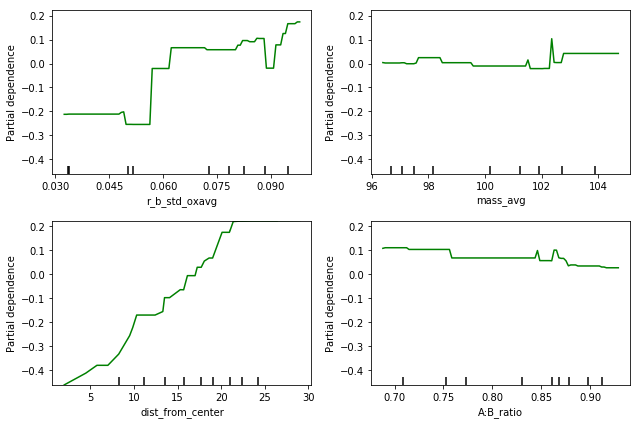

In [90]:
feature_names = ['r_b_std_oxavg','mass_avg','dist_from_center','A:B_ratio']
features = []
for fn in feature_names:
    idx = list(base_features).index(fn)
    features.append(idx)

fig, ax = plt.subplots(figsize=(9,6))    
plot_partial_dependence(rf,X,features,feature_names=base_features,n_cols=2,ax=ax)
fig.tight_layout()

## Elastic net

In [138]:
lr = ElasticNet(l1_ratio=0.5,alpha=1e-3,max_iter=1e4)
ss = StandardScaler()
Xts = ss.fit_transform(Xt)
lr.fit(Xts,y)
lr.score(Xts,y)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.794402794585505

## Kernel ridge regression

In [288]:
X_train = np.random.rand(10,2)*2
y_train = X_train[:,0] + 2*X_train[:,1]**2

X_test = np.random.rand(5,2)*2


kr = KernelRidge(alpha=1,kernel='linear',degree=2)
kr.fit(X_train,y_train)
kr.score(X_train,y_train)

0.8980922047139152

In [265]:
kr.dual_coef_

array([ 0.17754375, -0.49813346,  0.64714814,  0.67505221, -0.31075644,
       -0.42144016, -0.43373424,  0.29592033,  0.24567388, -0.29737871])

In [289]:
kr.predict(X_train)

array([2.69915056, 2.07289188, 2.91703165, 2.70917637, 1.6347243 ,
       0.32591691, 0.24484561, 1.88650507, 2.18349565, 2.52201813])

In [290]:
kr._get_kernel(X_train)@kr.dual_coef_

array([2.69915056, 2.07289188, 2.91703165, 2.70917637, 1.6347243 ,
       0.32591691, 0.24484561, 1.88650507, 2.18349565, 2.52201813])

In [291]:
X_train@X_train.T@kr.dual_coef_

array([2.69915056, 2.07289188, 2.91703165, 2.70917637, 1.6347243 ,
       0.32591691, 0.24484561, 1.88650507, 2.18349565, 2.52201813])

In [294]:
kr.predict(X_test)

array([1.32643671, 3.25109119, 2.03693087, 4.4140696 , 2.78262664])

In [293]:
X_test@X_train.T@kr.dual_coef_

array([1.32643671, 3.25109119, 2.03693087, 4.4140696 , 2.78262664])

In [287]:
x1 = X_test[0,:]
x1
kr.predict(x1[None,:])

array([3.78886226])

In [252]:
polynomial_kernel(X_test,X_test, degree=2)

array([[ 6.85507764,  7.7129359 ,  5.12174866,  4.3422333 ,  5.20600258,
         6.35721196,  1.34472   ,  5.78122174,  6.87715154,  7.66683188],
       [ 7.7129359 ,  8.7230242 ,  5.5883749 ,  4.86919361,  5.62915876,
         7.26983349,  1.38971861,  6.61922715,  7.87224849,  8.52960201],
       [ 5.12174866,  5.5883749 ,  5.36311735,  2.60607307,  6.23471174,
         3.3373425 ,  1.15373017,  2.77361371,  3.71463082,  7.26298657],
       [ 4.3422333 ,  4.86919361,  2.60607307,  3.56657832,  2.27932221,
         5.16285485,  1.30496418,  5.03164517,  5.40434518,  3.85752923],
       [ 5.20600258,  5.62915876,  6.23471174,  2.27932221,  7.63096119,
         2.76253085,  1.1034469 ,  2.14297881,  3.14938922,  8.25980298],
       [ 6.35721196,  7.26983349,  3.3373425 ,  5.16285485,  2.76253085,
         7.97848341,  1.45263457,  7.7918121 ,  8.38703389,  5.37979582],
       [ 1.34472   ,  1.38971861,  1.15373017,  1.30496418,  1.1034469 ,
         1.45263457,  1.04748742,  1.45070451

In [254]:
kr._get_kernel(X_test)

array([[ 5.84967117,  1.43318925,  8.42463796,  2.68596126,  4.27019214],
       [ 1.43318925,  1.08545858,  1.82140307,  1.14763818,  1.32936933],
       [ 8.42463796,  1.82140307, 16.43130611,  3.07510769,  6.04338636],
       [ 2.68596126,  1.14763818,  3.07510769,  1.71337232,  2.17417865],
       [ 4.27019214,  1.32936933,  6.04338636,  2.17417865,  3.25180475]])

Text(0,0.5,'$x_2$')

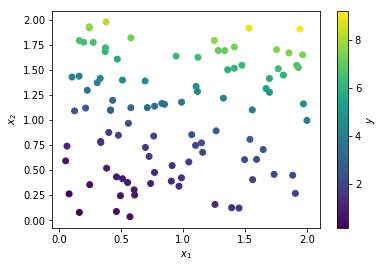

In [237]:
fig, ax = plt.subplots()
cm = ax.scatter(X_test[:,0],X_test[:,1],c=y_test)
cbar = fig.colorbar(cm,label='$y$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')


In [150]:
test = np.arange(6).reshape(3,2)
test

array([[0, 1],
       [2, 3],
       [4, 5]])

In [151]:
polynomial_kernel(test,test,degree=2)

array([[  2.25,   6.25,  12.25],
       [  6.25,  56.25, 156.25],
       [ 12.25, 156.25, 462.25]])

In [199]:
kr = KernelRidge(alpha=1e-3,kernel='poly',degree=1)
ss = StandardScaler()
Xs = ss.fit_transform(X)
kr.fit(Xs,y)
kr.score(Xs,y)

0.7131856473442314

In [200]:
kr.dual_coef_

array([-4.82693871e+02, -2.56296983e+02,  2.23091573e+02,  2.15937740e+02,
        1.76829958e+02,  3.22294592e+01, -7.24404713e+01, -2.95803615e+02,
       -1.06130524e+02, -1.03118735e+03, -1.04273184e+03, -4.81883892e+02,
       -8.09971820e+01, -4.69450538e+01, -1.14758140e+02,  8.21381107e+01,
       -4.61804969e+00, -1.11702860e+02, -2.53937474e+02, -3.45755052e+02,
       -3.56355258e+02, -7.11622885e+02,  3.48019250e+02,  3.03830658e+02,
        3.49572781e+02,  2.55952349e+02,  2.09274141e+02,  1.78342082e+02,
        1.68539526e+02,  1.87912677e+02,  1.75044039e+02,  3.50535746e+00,
       -1.87880811e+02,  4.43943887e+02,  3.70360244e+02,  4.60488032e+02,
        4.00144141e+02,  3.99000840e+02,  3.14909542e+02,  2.77642140e+02,
        2.63661295e+02,  2.81287989e+02,  1.98960431e+02, -7.30441065e+02,
       -2.48457933e+02, -3.27704496e+02,  6.36078859e+02, -3.11343817e+02,
       -3.01060437e+02, -3.76537448e+02, -6.06128908e+02, -5.76602960e+02,
        3.74156565e+02, -

In [201]:
kr.kernel

'poly'

In [188]:
dir(kr)

['X_fit_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_kernel',
 '_get_param_names',
 '_pairwise',
 'alpha',
 'coef0',
 'degree',
 'dual_coef_',
 'fit',
 'gamma',
 'get_params',
 'kernel',
 'kernel_params',
 'predict',
 'score',
 'set_params']

In [194]:
kr.dual_coef_.shape

(645,)

In [195]:
Xts.shape

(645, 300)

In [180]:
def multi_min(arrays):
    mins = []
    for arr in arrays:
        mins.append(min(arr))
    return min(mins)

def multi_max(arrays):
    maxs = []
    for arr in arrays:
        maxs.append(max(arr))
    return max(maxs)

def KFold_cv(X,y,estimator,k=5):
    kf = KFold(k,shuffle=True,random_state=7)
    train_scores = np.empty(k)
    test_scores = np.empty(k)
    actual = np.array([])
    pred = np.array([])
    for i, (train_index,test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        estimator.fit(X_train,y_train)
        train_scores[i] = estimator.score(X_train,y_train)
        test_scores[i] = estimator.score(X_test,y_test)
        actual = np.concatenate((actual,y_test))
        pred = np.concatenate((pred, estimator.predict(X_test)))
    
    return actual, pred, train_scores, test_scores
    
def KFold_pva(X,y,estimator,k=5,ax=None,logscale=False,s=10):
    y, y_pred, train_scores, test_scores = KFold_cv(X,y,estimator,k=k)
    if ax is None:
        fig, ax = plt.subplots()
    axmin = multi_min([y,y_pred])
    axmax = multi_max([y,y_pred])
    if logscale==False:
        ax.scatter(y,y_pred,s=s)
        ax.plot([axmin,axmax],[axmin,axmax],'g')
    elif logscale==True:
        ax.loglog(y,y_pred,'o',markersize=s)
        ax.loglog([axmin,axmax],[axmin,axmax],'g')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    
    return train_scores, test_scores
        

In [198]:
ss = StandardScaler()
Xts = ss.fit_transform(Xt) #poly-transformed dataset
Xs = ss.fit_transform(X) #original dataset

def kr_test(alpha,kernel,degree):
    kr = KernelRidge(alpha=alpha,kernel=kernel,degree=degree)
    train_scores, test_scores = KFold_pva(Xs,y,kr)
    print('Train scores: ', train_scores)
    print('Test scores: ', test_scores)
    print('Avg train score: ', np.mean(train_scores))
    print('Avg test score: ', np.mean(test_scores))
    
interact(
    kr_test,
    alpha = np.logspace(-5,2,20),
    kernel = ['linear','poly','rbf','laplacian','sigmoid','chi2'],
    degree = np.arange(1,10)
        )

#best results:
#Using Xts:
#linear: alpha = 18.3298: 0.768 avg test score
#poly: alpha = 0.1128, degree=1: 0.770 avg test score
#poly: alpha = 0.6158, degree=2: 0.779 avg test score
#poly: alpha = 1.4384, degree=3: 0.774 avg test score
#rbf: alpha = 0.0483: 0.721 avg test score
#laplacian: alpha = 0.1129: 0.803 avg test score
#sigmoid: alpha=3.3598: 0.461 avg test score

#Using Xs:
#poly: alpha=2.3357e-5, degree=2: 0.790 avg test score
#poly: alpha=0.0483, degree=3: 0.782 avg test score
#rbf: alpha=0.0088: 0.799 avg test score
#laplacian: alpha=0.1128: 0.810 avg test score


C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


interactive(children=(Dropdown(description='alpha', options=(1e-05, 2.3357214690901213e-05, 5.4555947811685143e-05, 0.00012742749857031334, 0.00029763514416313193, 0.0006951927961775605, 0.001623776739188721, 0.00379269019073225, 0.008858667904100823, 0.02069138081114788, 0.04832930238571752, 0.11288378916846883, 0.26366508987303555, 0.6158482110660255, 1.438449888287663, 3.359818286283781, 7.847599703514606, 18.32980710832434, 42.81332398719387, 100.0), value=1e-05), Dropdown(description='kernel', options=('linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'chi2'), value='linear'), Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output()), _dom_classes=('widget-interact',))

<function __main__.kr_test>